In [1]:
import matplotlib.pyplot as plt
import numpy as np
import flet as ft
import io
import base64
from pylsl import StreamInlet, resolve_stream
from scipy.signal import welch, spectrogram
import pyxdf

Authorization classes are not loaded, using fake implementations.


In [2]:
from scipy.signal import butter, lfilter, welch, filtfilt, iirnotch
import datetime
# Create a function to design a filter (function output b, a = filter coefficients)
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs # define nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandstop(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    
    return b, a
# Create a function to re-reference data to CAR
def common_average_reference(data):
    common_average = np.mean(data, axis=0) # For each channel we calculate the average across time points
    data_car = data - common_average
    return data_car


In [67]:
streams, header = pyxdf.load_xdf('../../../data_ssvep/Toey/SSVEP_data/0Hz/0hz_4')
raw_data = streams[0]["time_series"].T #From Steam variable this query is EEG data

In [68]:
raw_data.shape

(8, 15150)

In [69]:
# data = raw_data[0:4, 2000:3000]
data = raw_data[0:4,:]
data.shape

(4, 15150)

In [70]:
# data = common_average_reference(data)

In [71]:
# fs = 250
# lowcut = 2
# highcut = 50
# order = 1
# b, a = butter_bandpass(lowcut, highcut, fs, order)
# filtered_data = filtfilt(b,a, data)
# print(filtered_data.shape)
# fs = 250 
# f0 = 31   
# Q = 30    
# b, a = iirnotch(f0, Q, fs)
# filtered_data = filtfilt(b, a, filtered_data)
# fs = 250 
# lowcut = 30 
# highcut = 33  
# order = 10
# s = datetime.datetime.now()
# b, a = butter_bandstop(lowcut, highcut, fs, order)
# filtered_data = filtfilt(b, a, filtered_data)
# r = datetime.datetime.now() - s
# print(r)
filtered_data = data

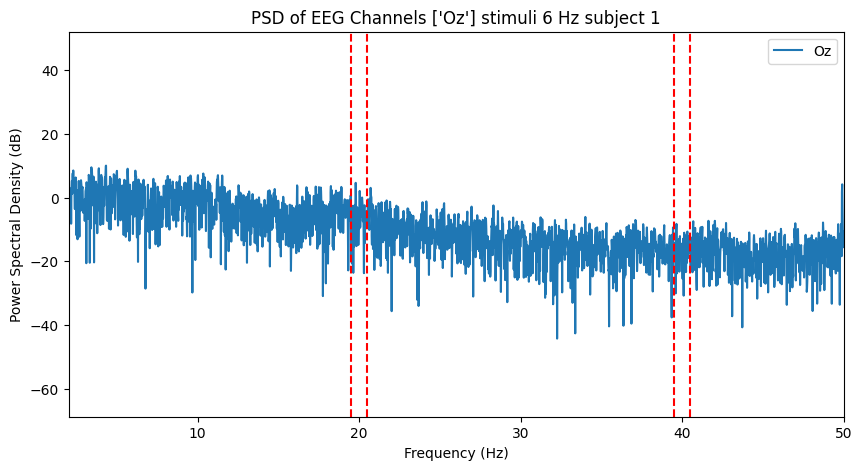

In [72]:
selected_channels = ['Oz']  # เลือกช่องที่ต้องการพล็อต
channels = ['Oz', 'Pz', 'O2', 'O1']
sfr = 6
subject = 1
                
plt.figure(figsize=(10, 5))  # สร้างกราฟเพียงครั้งเดียว
for selected_channel in selected_channels:
    channel_index = channels.index(selected_channel)
    f, Pxx = welch(filtered_data[channel_index] - filtered_data[1], fs=250, nperseg=len(data[channel_index]))
    # f, Pxx = welch(filtered_data[channel_index] - filtered_data[1], fs=250, nperseg= 250*4)
    # noverlap = nperseg//2
    psds_mean = np.mean(Pxx)

    plt.plot(f, 10 * np.log10(Pxx), label=f'{selected_channel}')  # เพิ่ม label ให้แต่ละช่อง

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.title(f'PSD of EEG Channels {selected_channels} stimuli {sfr} Hz subject {subject}')
    plt.axvline(x=19.5, color='r', linestyle='--') 
    plt.axvline(x=20.5, color='r', linestyle='--') 
    plt.axvline(x=39.5, color='r', linestyle='--') 
    plt.axvline(x=40.5, color='r', linestyle='--') 
    plt.legend()
    plt.xlim([2, 50])
    plt.legend()

In [73]:
len(f)

7576

In [74]:
f[0:120]

array([0.        , 0.01650165, 0.0330033 , 0.04950495, 0.0660066 ,
       0.08250825, 0.0990099 , 0.11551155, 0.1320132 , 0.14851485,
       0.1650165 , 0.18151815, 0.1980198 , 0.21452145, 0.2310231 ,
       0.24752475, 0.2640264 , 0.28052805, 0.2970297 , 0.31353135,
       0.330033  , 0.34653465, 0.3630363 , 0.37953795, 0.3960396 ,
       0.41254125, 0.4290429 , 0.44554455, 0.4620462 , 0.47854785,
       0.4950495 , 0.51155116, 0.52805281, 0.54455446, 0.56105611,
       0.57755776, 0.59405941, 0.61056106, 0.62706271, 0.64356436,
       0.66006601, 0.67656766, 0.69306931, 0.70957096, 0.72607261,
       0.74257426, 0.75907591, 0.77557756, 0.79207921, 0.80858086,
       0.82508251, 0.84158416, 0.85808581, 0.87458746, 0.89108911,
       0.90759076, 0.92409241, 0.94059406, 0.95709571, 0.97359736,
       0.99009901, 1.00660066, 1.02310231, 1.03960396, 1.05610561,
       1.07260726, 1.08910891, 1.10561056, 1.12211221, 1.13861386,
       1.15511551, 1.17161716, 1.18811881, 1.20462046, 1.22112

In [75]:
Pxx

array([5.7201064e+03, 4.5920391e+04, 5.2885347e+03, ..., 4.0570581e-03,
       7.5015996e-04, 3.7773310e-03], dtype=float32)

In [76]:
len(Pxx)

7576

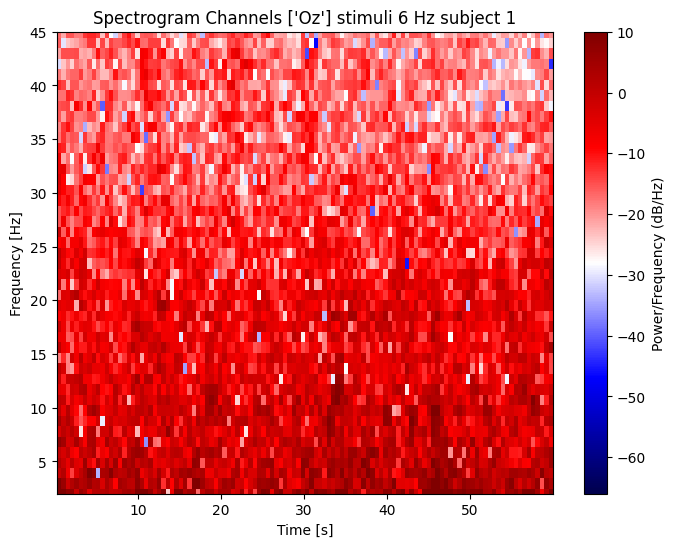

In [77]:
f, t, Sxx = spectrogram(filtered_data[channel_index] - filtered_data[1], fs=fs, noverlap=fs//2)

# มาสก์ค่าใน Sxx ที่ต่ำกว่า 10
Sxx_masked = np.ma.masked_less(10 * np.log10(Sxx), 10)

# พล็อต Spectrogram
plt.figure(figsize=(8, 6))
plt.ylim([2, 45])  # กำหนดช่วงความถี่
plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='seismic')  # พล็อต Spectrogram
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title(f'Spectrogram Channels {selected_channels} stimuli {sfr} Hz subject {subject}')
plt.clim([10, -60])  # กำหนดช่วงสี
plt.show()

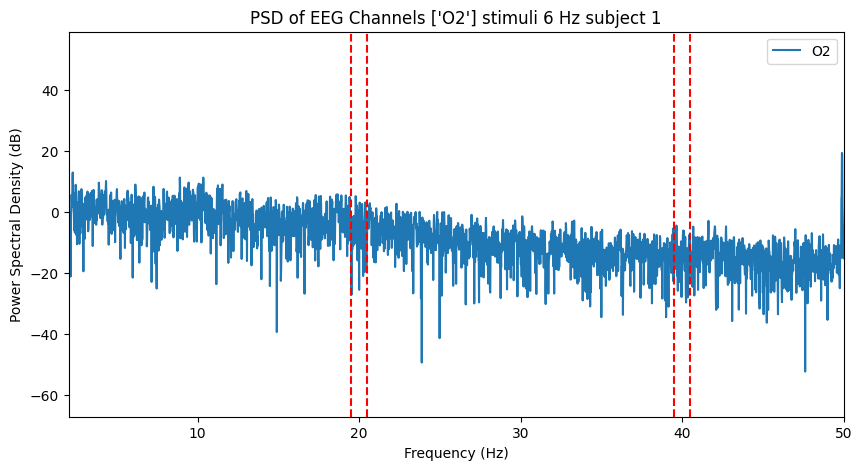

In [78]:
selected_channels = ['O2']  # เลือกช่องที่ต้องการพล็อต
channels = ['Oz', 'Pz', 'O2', 'O1']
sfr = 6
                
plt.figure(figsize=(10, 5))  # สร้างกราฟเพียงครั้งเดียว
for selected_channel in selected_channels:
    channel_index = channels.index(selected_channel)
    f, Pxx = welch(filtered_data[channel_index] - filtered_data[1], fs=250, nperseg=len(data[channel_index]))
    psds_mean = np.mean(Pxx)

    plt.plot(f, 10 * np.log10(Pxx), label=f'{selected_channel}')  # เพิ่ม label ให้แต่ละช่อง

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.title(f'PSD of EEG Channels {selected_channels} stimuli {sfr} Hz subject {subject}')
    plt.axvline(x=19.5, color='r', linestyle='--') 
    plt.axvline(x=20.5, color='r', linestyle='--') 
    plt.axvline(x=39.5, color='r', linestyle='--') 
    plt.axvline(x=40.5, color='r', linestyle='--')   
    plt.legend()
    plt.xlim([2, 50])
    plt.legend()

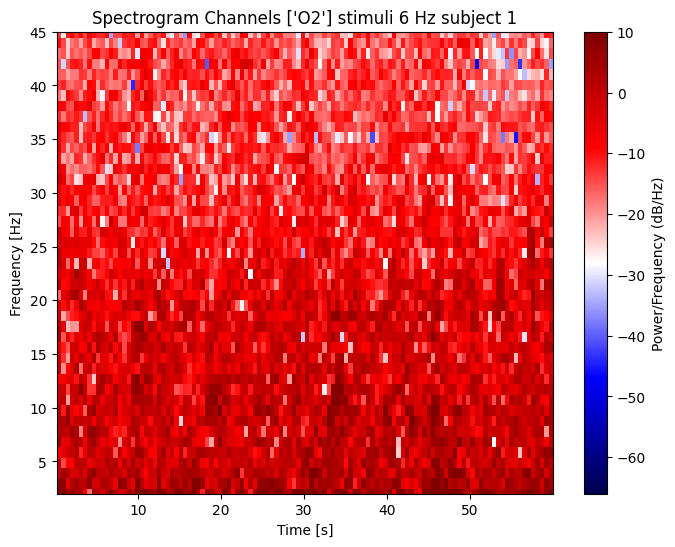

In [79]:
f, t, Sxx = spectrogram(filtered_data[channel_index] - filtered_data[1], fs=fs, noverlap=fs//2)

# มาสก์ค่าใน Sxx ที่ต่ำกว่า 10
Sxx_masked = np.ma.masked_less(10 * np.log10(Sxx), 10)

# พล็อต Spectrogram
plt.figure(figsize=(8, 6))
plt.ylim([2, 45])  # กำหนดช่วงความถี่
plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='seismic')  # พล็อต Spectrogram
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title(f'Spectrogram Channels {selected_channels} stimuli {sfr} Hz subject {subject}')
plt.clim([10, -60])  # กำหนดช่วงสี
plt.show()

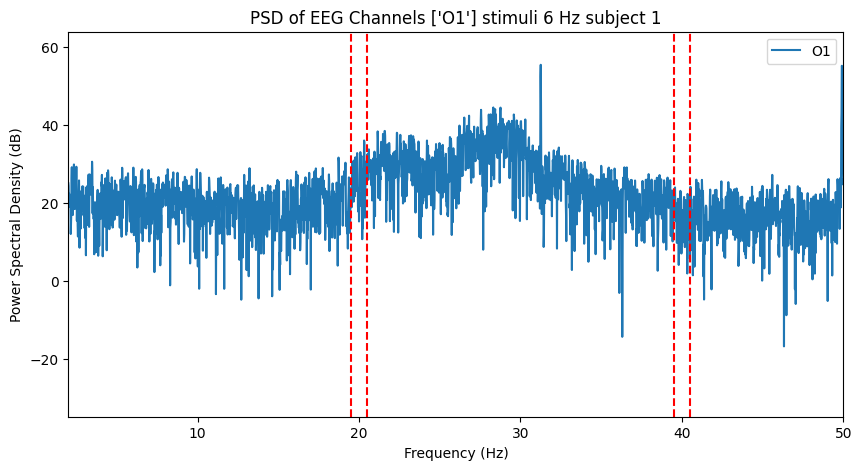

In [80]:
selected_channels = ['O1']  # เลือกช่องที่ต้องการพล็อต
channels = ['Oz', 'Pz', 'O2', 'O1']
sfr = 6
                
plt.figure(figsize=(10, 5))  # สร้างกราฟเพียงครั้งเดียว
for selected_channel in selected_channels:
    channel_index = channels.index(selected_channel)
    f, Pxx = welch(filtered_data[channel_index] - filtered_data[1], fs=250, nperseg=len(data[channel_index]))
    psds_mean = np.mean(Pxx)

    plt.plot(f, 10 * np.log10(Pxx), label=f'{selected_channel}')  # เพิ่ม label ให้แต่ละช่อง

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.title(f'PSD of EEG Channels {selected_channels} stimuli {sfr} Hz subject {subject}')
    plt.axvline(x=19.5, color='r', linestyle='--') 
    plt.axvline(x=20.5, color='r', linestyle='--') 
    plt.axvline(x=39.5, color='r', linestyle='--') 
    plt.axvline(x=40.5, color='r', linestyle='--') 
    plt.legend()
    plt.xlim([2, 50])
    plt.legend()

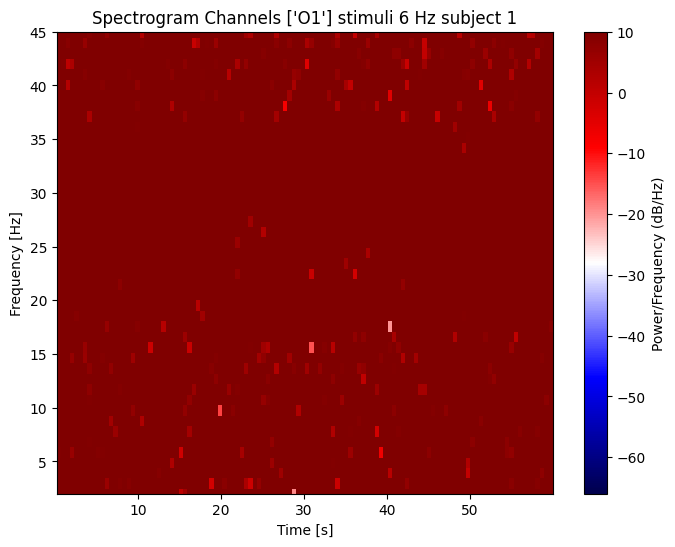

In [81]:
f, t, Sxx = spectrogram(filtered_data[channel_index] - filtered_data[1], fs=fs, noverlap=fs//2)

# มาสก์ค่าใน Sxx ที่ต่ำกว่า 10
Sxx_masked = np.ma.masked_less(10 * np.log10(Sxx), 10)

# พล็อต Spectrogram
plt.figure(figsize=(8, 6))
plt.ylim([2, 45])  # กำหนดช่วงความถี่
plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='seismic')  # พล็อต Spectrogram
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title(f'Spectrogram Channels {selected_channels} stimuli {sfr} Hz subject {subject}')
plt.clim([10, -60])  # กำหนดช่วงสี
plt.show()

In [82]:
# f, t, Sxx = spectrogram(filtered_data[channel_index] - filtered_data[1], fs=fs, noverlap=fs//2)

# # มาสก์ค่าใน Sxx ที่ต่ำกว่า 10
# Sxx_masked = np.ma.masked_less(10 * np.log10(Sxx), 10)

# # พล็อต Spectrogram
# plt.figure(figsize=(8, 6))
# plt.ylim([2, 50])  # กำหนดช่วงความถี่
# plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='seismic')  # พล็อต Spectrogram
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')
# plt.colorbar(label='Power/Frequency (dB/Hz)')
# plt.title('Spectrogram')
# plt.clim([10, -40])  # กำหนดช่วงสี
# plt.show()

In [32]:
# # มาสก์ค่าใน Sxx ที่ต่ำกว่า 10
# Sxx_masked = np.ma.masked_less(10 * np.log10(Sxx), -60)

# # พล็อต Spectrogram
# plt.figure(figsize=(8, 6))
# plt.ylim([2, 40])  # กำหนดช่วงความถี่
# plt.pcolormesh(t, f, Sxx_masked, cmap='seismic')  # พล็อต Spectrogram
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')
# plt.colorbar(label='Power/Frequency (dB/Hz)')
# plt.title('Spectrogram with values below 10 masked')
# plt.clim([10, -40])  # กำหนดช่วงสี
# plt.show()